In [29]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.linalg import sqrtm
from numpy.linalg import det
import numpy.linalg as LA
import matplotlib.pyplot as plt
import math

def generate_covariance(true_mu, dims):
    S = np.tril(np.random.randn(dims, dims))
    cov = np.dot(S, S.T)
    while(np.linalg.det(cov) < 0.5):
        cov = cov * 2
    mu = np.random.multivariate_normal(true_mu, cov, 1)[0]

    return mu, cov

def get(dims):
    true_mu = np.zeros((dims, ))

    x_ac, C_ac = generate_covariance(true_mu, dims)
    x_c, C_c = generate_covariance(true_mu, dims)
    x_bc, C_bc = generate_covariance(true_mu, dims)

    C_a = LA.inv(LA.inv(C_ac) + LA.inv(C_c))
    C_b = LA.inv(LA.inv(C_bc) + LA.inv(C_c))

    x_a = C_a @ (LA.inv(C_ac) @ x_ac + LA.inv(C_c) @ x_c)
    x_b = C_b @ (LA.inv(C_bc) @ x_bc + LA.inv(C_c) @ x_c)

    C_fus = LA.inv(LA.inv(C_a) + LA.inv(C_b) - LA.inv(C_c))

    return x_a.reshape(1, dims), x_b.reshape(1, dims), C_a, C_b, C_fus


In [30]:
def plot_ellipse(covariance, ax, label_t="", linestyle='', alpha_val=0.25, color_def='red', center = [0, 0]):
    if covariance.shape[0] == 2:
        x_el = np.array([np.sin(np.linspace(0, 2*math.pi, num=63)), np.cos(np.linspace(0, 2*math.pi, num=63))])
        C = np.linalg.cholesky(covariance)
        y_el = np.dot(C, x_el)
        if len(linestyle) > 0:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def, linestyle=linestyle)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def, linestyle=linestyle)            
        else:
            if len(label_t) > 0:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], label=label_t, alpha=alpha_val, color=color_def)
            else:
                ax.plot(y_el[0] + center[0], y_el[1] + center[1], alpha=alpha_val, color=color_def)            

def mutual_covariance(cov_a, cov_b):
    D_a, S_a = np.linalg.eigh(cov_a)
    D_a_sqrt = sqrtm(np.diag(D_a))
    D_a_sqrt_inv = inv(D_a_sqrt)
    M = np.dot(np.dot(np.dot(np.dot(D_a_sqrt_inv, inv(S_a)), cov_b), S_a), D_a_sqrt_inv)    # eqn. 10 in Sijs et al.
    D_b, S_b = np.linalg.eigh(M)
    D_gamma = np.diag(np.clip(D_b, a_min=1.0, a_max=None))   # eqn. 11b in Sijs et al.
    return np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(S_a, D_a_sqrt), S_b), D_gamma), inv(S_b)), D_a_sqrt), inv(S_a))  # eqn. 11a in Sijs et al

In [31]:
x_a, x_b, C_a, C_b, C_fus = get(2)

x_a = x_a.reshape(1, 2)
x_b = x_b.reshape(1, 2)

def get_critical_value(dimensions, alpha):
    return chi2.ppf((1 - alpha), df=dimensions)

eta = get_critical_value(2, 0.05)

def inv(mat):
    return np.linalg.inv(mat)

In [32]:
def objective(S):
    return -(S[0]*S[3])

def constraint1(S):
    S = S.reshape(2, 2)
    A = inv(C_a) - inv(inv(S.T) @ inv(S))
    return np.linalg.eig(A)[0][0]
def constraint2(S):
    S = S.reshape(2, 2)
    A = inv(C_a) - inv(inv(S.T) @ inv(S))
    return np.linalg.eig(A)[0][1]
def constraint3(S):
    S = S.reshape(2, 2)
    A = inv(C_b) - inv(inv(S.T) @ inv(S))
    return np.linalg.eig(A)[0][0]
def constraint4(S):
    S = S.reshape(2, 2)
    A = inv(C_b) - inv(inv(S.T) @ inv(S))
    return np.linalg.eig(A)[0][1]
    


def prob_constraint(S):
    S = S.reshape(2, 2)
    C_c_inv = inv(inv(S.T) @ inv(S))
    C_ac = inv(inv(C_a) - C_c_inv)
    C_bc = inv(inv(C_b) - C_c_inv)
    x_c = (inv(inv(C_ac) + inv(C_bc)) @ (inv(C_ac) @ x_a.T + inv(C_bc) @ x_b.T - C_c_inv@(x_a + x_b).T)).T
    x_ac = (C_ac @ (inv(C_a) @ x_a.T - C_c_inv @ x_c.T)).T
    x_bc =(C_bc @ (inv(C_b) @ x_b.T - C_c_inv @ x_c.T)).T
    f = abs(((x_ac - x_bc) @ inv(C_ac + C_bc) @ (x_ac - x_bc).T)[0][0])
    return eta - f

def constraint5(S):
    return 1e-30 - abs(S[2])

b = (-np.inf, np.inf)
bnds = (b, b, b, b)

In [33]:
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'ineq', 'fun': constraint4}
con5 = {'type': 'ineq', 'fun': prob_constraint}
con6 = {'type': 'ineq', 'fun': constraint5}
cons = [con1, con2, con3, con4, con5, con6]


In [34]:
S_0 = (np.linalg.cholesky(inv(mutual_covariance(C_a, C_b))).T).reshape(4, )
print(S_0)


[2.71071846 2.3733683  0.         1.19605584]


In [38]:
sol = minimize(objective, S_0, method='COBYLA', constraints=cons)

In [39]:
print(sol)

     fun: -5.73227440195194
   maxcv: 1.2615698255310281
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 236
  status: 4
 success: False
       x: array([2.29280016, 1.15145769, 0.81084737, 2.50011951])


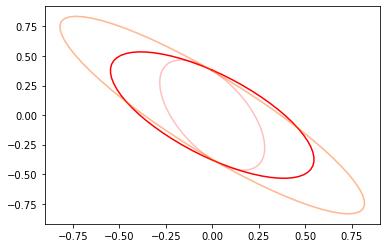

[[2.29280016 1.15145769]
 [0.81084737 2.50011951]]


<Figure size 432x288 with 0 Axes>

In [40]:
S = sol.x
S = S.reshape(2, 2)

C_c = inv(S.T) @ inv(S)


ax = plt.axes()
plot_ellipse(C_c, ax, alpha_val=1)
plot_ellipse(C_a, ax)
plot_ellipse(C_b, ax)
plot_ellipse(mutual_covariance(C_a, C_b), ax, color_def='orange')
plt.show()
plt.cla()
plt.clf()

print(S)

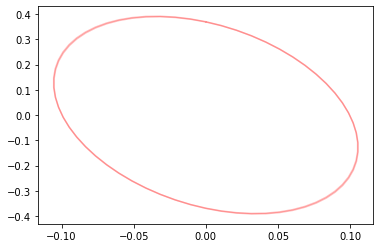

In [26]:
ax = plt.axes()
fus_PC = inv(inv(C_a) + inv(C_b) - inv(C_c))
fus_EI = inv(inv(C_a) + inv(C_b) - inv(mutual_covariance(C_a, C_b)))
plot_ellipse(fus_PC, ax)
plot_ellipse(fus_EI, ax)
plt.show()